# ICBC Project: Loan Defualt Prediction

#### Author: Ewen

## 0: Introduction

## 1: Package Importing

In [2]:
print('Importing packages...')
import os 
from datetime import datetime
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import cross_validation, metrics   
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc 
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import seaborn as sns
%matplotlib inline
rcParams['figure.figsize'] = 12, 4

Importing packages...


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## 2: Data Loading

In [3]:
print('Setting the work director...')
wd = '/Users/ewenwang/OneDrive/IBM/Project_ICBC/code_wu'
os.chdir(wd)

print('Loading the data...')
DataFile = "dataset_fe.csv"
dataset = pd.read_csv(DataFile)
target = 'loan_status'
predictors = [x for x in dataset.columns if x not in [target]]

# split data into train and test sets
seed, test_size = 2017, .33
dtrain, dtest = train_test_split(dataset, test_size=test_size, random_state=seed)

print('Done.')

Setting the work director...
Loading the data...
Done.


## 3. Exploratory Data Analysis

In [4]:
dataset.head(4)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,Home buying,Home improvement,Major purchase,Medical expenses,Moving and relocation,Other,Vacation,DIRECT_PAY,INDIVIDUAL,JOINT
0,15000,15000,15000,0,0.14,512.60,3,34,3,2.0,...,0,0,0,0,0,0,0,0,1,0
1,2600,2600,2600,0,0.09,82.67,2,20,2,3.0,...,0,0,0,0,1,0,0,0,1,0
2,32200,32200,32200,1,0.21,880.02,4,48,0,10.0,...,0,0,0,0,0,0,0,0,1,0
3,10000,10000,10000,0,0.11,329.72,2,28,1,10.0,...,0,0,0,0,0,0,0,0,1,0


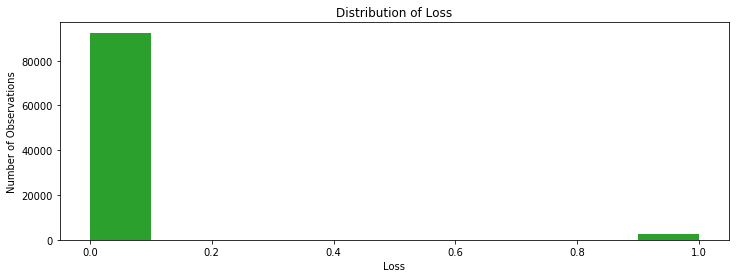

In [7]:
# histgram
p = sns.color_palette()
plt.hist(dataset.loan_status, color = p[2])
plt.ylabel('Number of Observations')
plt.xlabel('Loss')
plt.title('Distribution of Loss')
plt.show()

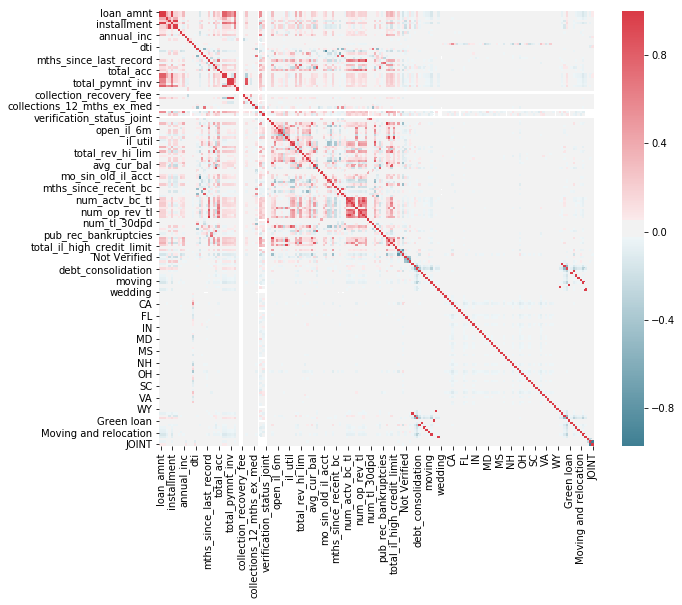

In [8]:
# heatmap
f, ax = plt.subplots(figsize = (10, 8))
corr = dataset.corr()
sns.heatmap(corr,
            mask=np.zeros_like(corr, dtype = np.bool),
            cmap = sns.diverging_palette(220, 10, as_cmap = True),
            square = True,
            ax = ax)

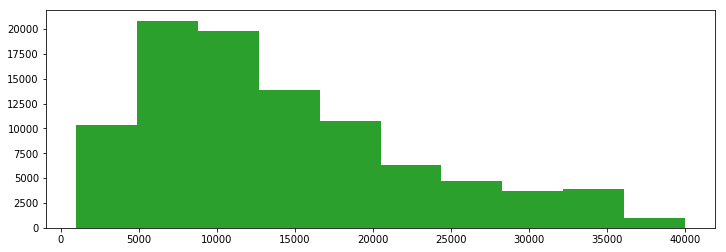

In [9]:
plt.hist(dataset.loan_amnt, color = p[2])
plt.show()

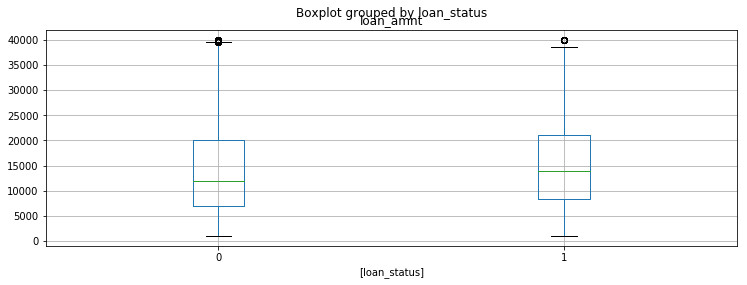

In [10]:
loan_amount = pd.DataFrame(dataset[['loan_amnt', 'loan_status']])
loan_amount.boxplot(by = 'loan_status')

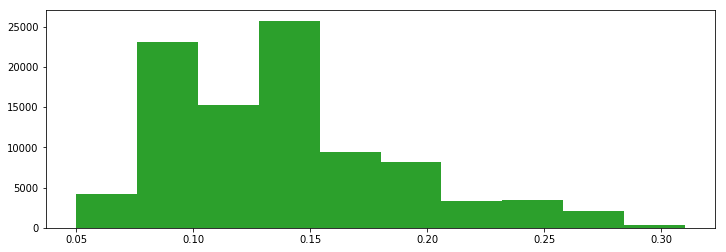

In [11]:
plt.hist(dataset.int_rate, color = p[2])
plt.show()

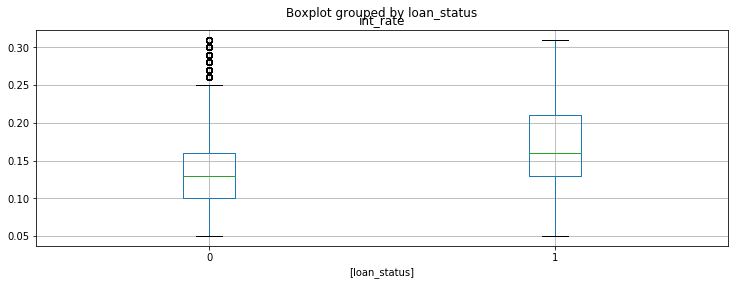

In [12]:
int_rate = pd.DataFrame(dataset[['int_rate', 'loan_status']])
int_rate.boxplot(by = 'loan_status')

## 4: Parameter Tuning

In [5]:
def modelfit(alg, dtrain, dtest, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        print('Start Cross Validation...')
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        xgtest = xgb.DMatrix(dtest[predictors].values)
        cvresult = xgb.cv(xgb_param, 
                          xgtrain, 
                          num_boost_round=alg.get_params()['n_estimators'], 
                          nfold=cv_folds,
                          metrics='auc', 
                          early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
        print(cvresult)
        print('Done.')
    
    #Fit the algorithm on the data
    print('Fitting the algorithm on the data...')
    alg.fit(dtrain[predictors], dtrain[target], eval_metric='auc')
        
    #Predict training set:
    print('Predicting training set...')
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain[target].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain[target], dtrain_predprob)) 
    
    #Predict on testing data:
    print('Predicting testing set...')
    dtest['predprob'] = alg.predict_proba(dtest[predictors])[:,1]
    print('AUC Score (Test): %f' % metrics.roc_auc_score(dtest[target], dtest['predprob']))
    
    #Print featuure importance:   
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    plt.show()

## 5: Model Training

Initializing xgboost.sklearn.XGBClassifier and starting training...
Start Cross Validation...
    test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0        0.957118      0.005378        0.958660       0.003913
1        0.981705      0.006684        0.983077       0.005186
2        0.983866      0.006462        0.985742       0.005721
3        0.988056      0.004025        0.990017       0.001295
4        0.987939      0.004062        0.989931       0.001465
5        0.989069      0.004778        0.990446       0.001341
6        0.990032      0.005534        0.990841       0.001348
7        0.989977      0.005441        0.991307       0.001606
8        0.989951      0.005511        0.991420       0.001394
9        0.989851      0.005456        0.991562       0.001498
10       0.989908      0.005223        0.991539       0.001381
11       0.989821      0.005468        0.991474       0.001431
12       0.989968      0.005190        0.991778       0.000887
13       0.989982      0

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


AUC Score (Test): 0.993130


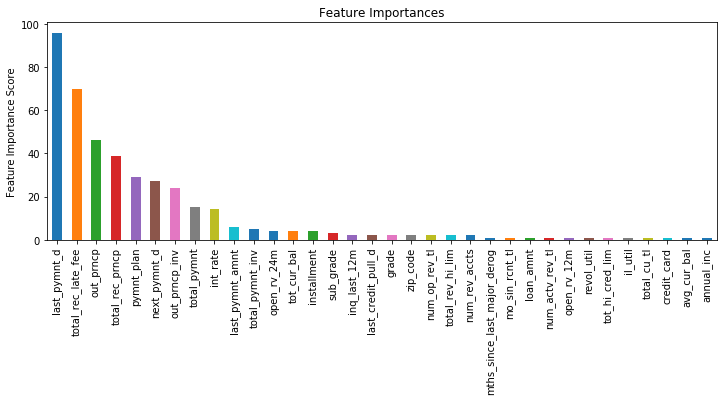

0:00:58.814020


In [6]:
print('Initializing and starting training...')

st = datetime.now()



print(datetime.now()-st)